### Import necessary modules

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import sklearn as sk
import datetime
import calendar
from jupyter_dash import JupyterDash
import dash
from dash import Dash, html, dcc, Input, Output
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import requests
import io
from plotly.subplots import make_subplots

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Set up Google Cloud BigQuery Request

In [2]:
from google.cloud import bigquery
!export GOOGLE_APPLICATION_CREDENTIALS="cse6242project-377400-2f98c9def7f8.json"
!gcloud auth activate-service-account --key-file cse6242project-377400-2f98c9def7f8.json

zsh:1: command not found: gcloud


In [3]:
import os

os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="cse6242project-377400-2f98c9def7f8.json"

In [4]:
import pandas as pd

In [5]:
# Initialize a BigQuery client
client = bigquery.Client()

In [6]:
table_ref = client.dataset('cse6242gbq').table('counts_table')
table = client.get_table(table_ref)

schema_df = pd.DataFrame([field.to_api_repr() for field in table.schema])

In [7]:
query = """
        SELECT * 
        FROM `cse6242project-377400.cse6242gbq.counts_table` 
        """
df = client.query(query).to_dataframe()
df.head(5)

date      time                       view  car  motorcycle  \
0  2023-02-15  11:19:11  View_from_Tuas_Checkpoint   15           0   
1  2023-02-17  11:21:04  View_from_Tuas_Checkpoint   17           0   
2  2023-02-17  15:13:21  View_from_Tuas_Checkpoint   18           0   
3  2023-02-20  13:14:32  View_from_Tuas_Checkpoint   15           0   
4  2023-02-20  14:18:19  View_from_Tuas_Checkpoint   15           0   

   large_vehicle  
0              9  
1              4  
2              5  
3              7  
4              5

### Data Preprocessing

In [8]:
df = df.sort_values(by=['date']).reset_index(drop=True)
display(df.head(5))

date      time                                        view  car  \
0  2023-02-14  22:36:03  View_from_Woodlands_Causeway_Towards_Johor    2   
1  2023-02-14  23:14:34  View_from_Woodlands_Checkpoint_Towards_BKE    0   
2  2023-02-14  22:36:03  View_from_Woodlands_Checkpoint_Towards_BKE    3   
3  2023-02-14  22:36:03               View_from_Second_Link_at_Tuas    0   
4  2023-02-14  23:14:34               View_from_Second_Link_at_Tuas    0   

   motorcycle  large_vehicle  
0           0              0  
1           0              0  
2           0              1  
3           0              1  
4           0              6

In [9]:
print(df.shape)
df['date'] = pd.to_datetime(df['date'], format = "%Y-%m-%d")
df['day'] = df['date'].dt.day_name()
df.drop(columns=['motorcycle'], axis=1, inplace=True)
df['vehicle'] = df['car'] + df['large_vehicle']
display(df.tail(5))

(11592, 6)


date      time                                              view  \
11587 2023-04-12  02:33:57  View_from_Woodlands_Causeway_Towards_Johor_to_jh   
11588 2023-04-12  03:05:44  View_from_Woodlands_Causeway_Towards_Johor_to_jh   
11589 2023-04-12  03:33:38  View_from_Woodlands_Causeway_Towards_Johor_to_jh   
11590 2023-04-12  04:33:29  View_from_Woodlands_Causeway_Towards_Johor_to_jh   
11591 2023-04-12  00:09:35                   View_from_Tuas_Checkpoint_to_jh   

       car  large_vehicle        day  vehicle  
11587    0              0  Wednesday        0  
11588    0              0  Wednesday        0  
11589    0              0  Wednesday        0  
11590    0              0  Wednesday        0  
11591    0              0  Wednesday        0

In [10]:
display(df['view'].unique())

array(['View_from_Woodlands_Causeway_Towards_Johor',
       'View_from_Woodlands_Checkpoint_Towards_BKE',
       'View_from_Second_Link_at_Tuas', 'View_from_Tuas_Checkpoint',
       'View_from_Tuas_Checkpoint_to_sg',
       'View_from_Second_Link_at_Tuas_to_jh',
       'View_from_Woodlands_Checkpoint_Towards_BKE_to_jh',
       'View_from_Woodlands_Checkpoint_Towards_BKE_to_sg',
       'View_from_Second_Link_at_Tuas_to_sg',
       'View_from_Tuas_Checkpoint_to_jh',
       'View_from_Woodlands_Causeway_Towards_Johor_to_jh',
       'View_from_Woodlands_Causeway_Towards_Johor_to_sg'], dtype=object)

In [11]:
transfer = {"View_from_Second_Link_at_Tuas_to_sg": 'Johor-Tuas', 
            "View_from_Second_Link_at_Tuas_to_jh": 'Tuas-Johor',
            "View_from_Tuas_Checkpoint_to_sg": 'Johor-Tuas',
            "View_from_Tuas_Checkpoint_to_jh": 'Tuas-Johor',
            "View_from_Woodlands_Causeway_Towards_Johor_to_sg": 'Johor-Woodlands',
            "View_from_Woodlands_Causeway_Towards_Johor_to_jh": 'Woodlands-Johor',
            "View_from_Woodlands_Checkpoint_Towards_BKE_to_sg": 'Johor-Woodlands',
            "View_from_Woodlands_Checkpoint_Towards_BKE_to_jh": 'Woodlands-Johor'}

new_table = df.replace({'view':transfer})
display(new_table.head(10))

date      time                                        view  car  \
0 2023-02-14  22:36:03  View_from_Woodlands_Causeway_Towards_Johor    2   
1 2023-02-14  23:14:34  View_from_Woodlands_Checkpoint_Towards_BKE    0   
2 2023-02-14  22:36:03  View_from_Woodlands_Checkpoint_Towards_BKE    3   
3 2023-02-14  22:36:03               View_from_Second_Link_at_Tuas    0   
4 2023-02-14  23:14:34               View_from_Second_Link_at_Tuas    0   
5 2023-02-14  22:36:03                   View_from_Tuas_Checkpoint    2   
6 2023-02-14  23:14:34                   View_from_Tuas_Checkpoint    1   
7 2023-02-14  23:14:34  View_from_Woodlands_Causeway_Towards_Johor    0   
8 2023-02-15  01:14:01               View_from_Second_Link_at_Tuas    0   
9 2023-02-15  07:14:45  View_from_Woodlands_Checkpoint_Towards_BKE    2   

   large_vehicle        day  vehicle  
0              0    Tuesday        2  
1              0    Tuesday        0  
2              1    Tuesday        4  
3              1    Tuesday        1  
4              6    Tuesday        6  
5              0    Tuesday        2  
6              0    Tuesday        1  
7              0    Tuesday        0  
8              3  Wednesday        3  
9              2  Wednesday        4

In [12]:
print(new_table.loc[:,'view'].unique())

['View_from_Woodlands_Causeway_Towards_Johor'
 'View_from_Woodlands_Checkpoint_Towards_BKE'
 'View_from_Second_Link_at_Tuas' 'View_from_Tuas_Checkpoint' 'Johor-Tuas'
 'Tuas-Johor' 'Woodlands-Johor' 'Johor-Woodlands']


In [13]:
options = ['Johor-Woodlands','Woodlands-Johor','Johor-Tuas','Tuas-Johor']
print(new_table.shape)

final_df = new_table[new_table['view'].isin(options)]
print(final_df.shape)

(11592, 7)
(9808, 7)


In [14]:
from datetime import datetime, timedelta

tim = df.loc[30,['time']][0]
print(tim)

def hour_rounder(t):
    if int(t.minute)>= 30:
        time_1 = str(int(t.hour)+1)
        if len(time_1) == 1:
            return "0"+time_1+":00"
        else:
            return str(time_1)+":00"
    else:
        if len(str(t.hour)) == 1:
            return "0"+str(t.hour)+":00"
        else:
            return str(t.hour)+":00"
hour_rounder(tim)

11:19:11


'11:00'

In [15]:
final_df.loc[:,'hour'] = final_df.loc[:,'time'].apply(hour_rounder)

display(final_df.head(5))

/var/folders/w8/7fvtd_nn7235fgdf50g59c5h0000gn/T/ipykernel_34059/2962692662.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.loc[:,'hour'] = final_df.loc[:,'time'].apply(hour_rounder)


date      time             view  car  large_vehicle      day  \
1720 2023-03-07  18:10:53       Johor-Tuas    1              0  Tuesday   
1721 2023-03-07  21:25:17       Tuas-Johor    0              1  Tuesday   
1722 2023-03-07  18:15:53  Woodlands-Johor    8              0  Tuesday   
1723 2023-03-07  18:15:53  Johor-Woodlands    0              0  Tuesday   
1724 2023-03-07  23:14:49       Johor-Tuas    0              3  Tuesday   

      vehicle   hour  
1720        1  18:00  
1721        1  21:00  
1722        8  18:00  
1723        0  18:00  
1724        3  23:00

In [16]:
final_table = final_df.groupby(['view', 'day', 'hour']).sum().reset_index().loc[:,['day', 'hour','view', 'vehicle']]
display(final_table.head(5))

day   hour        view  vehicle
0  Friday  00:00  Johor-Tuas        3
1  Friday  01:00  Johor-Tuas       15
2  Friday  02:00  Johor-Tuas       17
3  Friday  03:00  Johor-Tuas        6
4  Friday  04:00  Johor-Tuas       11

In [17]:
def peak_hours(t):
    peak = ['07:00', "08:00", '09:00', "17:00", "18:00", "19:00"]
    if t in peak:
        return 1
    else:
        return 0

In [18]:
def weekend(w):
    end = ['Saturday', 'Sunday']
    if w in end:
        return 1
    else:
        return 0

In [19]:
def vehicle_cat(v):
    if v >= 0 and v < 20:
        return 0
    elif v >= 20 and v < 50:
        return 1
    elif v >= 50 and v < 80:
        return 2
    elif v >= 80 and v < 120:
        return 3
    else:
        return 4    

In [20]:
final_table.loc[:,'peak'] = final_table.loc[:,'hour'].apply(peak_hours)
final_table.loc[:,'peak'] = final_table.loc[:,'peak'].astype('category')
final_table.loc[:,'weekend'] = final_table.loc[:,'day'].apply(weekend)
final_table.loc[:,'weekend'] = final_table.loc[:,'weekend'].astype('category')
final_table.loc[:,'cat'] = final_table.loc[:,'vehicle'].apply(vehicle_cat)
final_table.loc[:,'cat'] = final_table.loc[:,'cat'].astype('category')
display(final_table.head(5))

day   hour        view  vehicle peak weekend cat
0  Friday  00:00  Johor-Tuas        3    0       0   0
1  Friday  01:00  Johor-Tuas       15    0       0   0
2  Friday  02:00  Johor-Tuas       17    0       0   0
3  Friday  03:00  Johor-Tuas        6    0       0   0
4  Friday  04:00  Johor-Tuas       11    0       0   0

In [21]:
print(np.bincount(np.array(final_table.loc[:,'cat'])))

[450 121  64  45  20]


### Machine Learning Model Testing-Determining Self-Made Category of Traffic Congestion

In [22]:
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn import tree

Split the data and create dummy variables for each category

In [23]:
X = final_table.loc[:,['day', 'hour','view']]
Y = final_table.loc[:,'cat']

X = pd.get_dummies(X)
X.loc[:,['peak', 'weekend']] = final_table.loc[:,['peak', 'weekend']]
display(X)

x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.7,
                                                            test_size=0.3,
                                                            shuffle=True, random_state=13)

day_Friday  day_Monday  day_Saturday  day_Sunday  day_Thursday  \
0             1           0             0           0             0   
1             1           0             0           0             0   
2             1           0             0           0             0   
3             1           0             0           0             0   
4             1           0             0           0             0   
..          ...         ...           ...         ...           ...   
695           0           0             0           0             0   
696           0           0             0           0             0   
697           0           0             0           0             0   
698           0           0             0           0             0   
699           0           0             0           0             0   

     day_Tuesday  day_Wednesday  hour_00:00  hour_01:00  hour_02:00  ...  \
0              0              0           1           0           0  ...   
1              0              0           0           1           0  ...   
2              0              0           0           0           1  ...   
3              0              0           0           0           0  ...   
4              0              0           0           0           0  ...   
..           ...            ...         ...         ...         ...  ...   
695            0              1           0           0           0  ...   
696            0              1           0           0           0  ...   
697            0              1           0           0           0  ...   
698            0              1           0           0           0  ...   
699            0              1           0           0           0  ...   

     hour_21:00  hour_22:00  hour_23:00  hour_24:00  view_Johor-Tuas  \
0             0           0           0           0                1   
1             0           0           0           0                1   
2             0           0           0           0                1   
3             0           0           0           0                1   
4             0           0           0           0                1   
..          ...         ...         ...         ...              ...   
695           0           0           0           0                0   
696           1           0           0           0                0   
697           0           1           0           0                0   
698           0           0           1           0                0   
699           0           0           0           1                0   

     view_Johor-Woodlands  view_Tuas-Johor  view_Woodlands-Johor  peak  \
0                       0                0                     0     0   
1                       0                0                     0     0   
2                       0                0                     0     0   
3                       0                0                     0     0   
4                       0                0                     0     0   
..                    ...              ...                   ...   ...   
695                     0                0                     1     0   
696                     0                0                     1     0   
697                     0                0                     1     0   
698                     0                0                     1     0   
699                     0                0                     1     0   

     weekend  
0          0  
1          0  
2          0  
3          0  
4          0  
..       ...  
695        0  
696        0  
697        0  
698        0  
699        0  

[700 rows x 38 columns]

In [24]:
#Trial Decision tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print(accuracy_score(y_test, y_pred))
print(np.bincount(y_pred))
print(np.bincount(y_test))

0.6666666666666666
[132  46  17  10   5]
[133  35  19  15   8]


In [25]:
#Trial RandomForest
rf_clf = RandomForestClassifier(random_state=13).fit(x_train, y_train)
y_predict_train = rf_clf.predict(x_train)
y_predict_test = rf_clf.predict(x_test)
print(accuracy_score(y_train, y_predict_train))
print(accuracy_score(y_test, y_predict_test))
param_grid = {'n_estimators':[2,4,6,8,10], 'max_depth':[2,8,16,24]}
gscv_rfc = GridSearchCV(rf_clf, param_grid).fit(x_train, y_train)
print(gscv_rfc.best_params_)
print(gscv_rfc.best_score_)

print(np.bincount(y_predict_test))
print(np.bincount(y_test))

1.0
0.6857142857142857
{'max_depth': 16, 'n_estimators': 8}
0.6932253313696612
[160  29  12   6   3]
[133  35  19  15   8]


In [26]:
rf_clf = RandomForestClassifier(random_state=13, max_depth=16, n_estimators=8).fit(x_train, y_train)
y_predict_train = rf_clf.predict(x_train)
y_predict_test = rf_clf.predict(x_test)
print(accuracy_score(y_train, y_predict_train))
print(accuracy_score(y_test, y_predict_test))

print(np.bincount(y_predict_test))
print(np.bincount(y_test))

0.9447852760736196
0.6714285714285714
[159  27  14   5   5]
[133  35  19  15   8]


0.6619047619047619


/Users/roisinnichuireain/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/roisinnichuireain/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the val

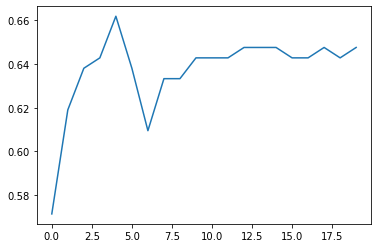

In [27]:
from sklearn.neighbors import KNeighborsClassifier
scores = []
for i in range(20):
    neigh = KNeighborsClassifier(n_neighbors=i+1)
    neigh.fit(x_train, y_train)
    y_pred = neigh.predict(x_test)
    scores.append(accuracy_score(y_test, y_pred))
plt.plot(scores)

b = np.argmax(list(scores))
neigh = KNeighborsClassifier(n_neighbors=b+1)
neigh.fit(x_train, y_train)
y_pred = neigh.predict(x_test)
print(accuracy_score(y_test, y_pred))

0.6666666666666666
[143  31  22  12   2]
[133  35  19  15   8]


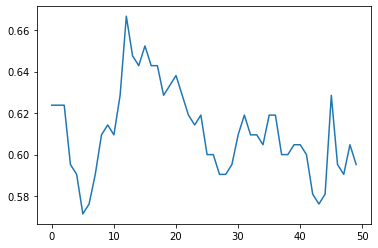

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

scores = []
for i in range(50):
    clf = AdaBoostClassifier(n_estimators=i+1)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    scores.append(accuracy_score(y_test, y_pred))
plt.plot(scores)

b = np.argmax(list(scores))
clf = AdaBoostClassifier(n_estimators=b+1)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(np.bincount(y_pred))
print(np.bincount(y_test))

In [29]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=0.65, hidden_layer_sizes=(4,3), random_state=2, max_iter=3000)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(np.bincount(y_pred))
print(np.bincount(y_test))

0.7428571428571429
[140  34  24  12]
[133  35  19  15   8]


In [30]:
#parameters = {"solver":['lbfgs', 'adam', 'sgd'],
             #'alpha':[0.005, 0.05, 0.5,1],
             #'hidden_layer_sizes':[(4,3), (5,3), (6,3)]}
#grid = GridSearchCV(clf, parameters).fit(x_train, y_train)
#print(grid.best_params_)
#print(grid.best_score_)

In [31]:
clf = MLPClassifier(solver='lbfgs', alpha=3, hidden_layer_sizes=(5,4), random_state=2, max_iter=3000)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(np.bincount(y_pred))
print(np.bincount(y_test))

0.7333333333333333
[134  44  22   7   3]
[133  35  19  15   8]


In [32]:
from sklearn.ensemble import GradientBoostingClassifier
GBC_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, 
                                     max_depth=1, random_state=1)
GBC_clf.fit(x_train, y_train)
y_pred = GBC_clf.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(np.bincount(y_pred))
print(np.bincount(y_test))

0.6523809523809524
[158  28  12   3   9]
[133  35  19  15   8]


In [33]:
parameters = {"n_estimators":[100, 200, 300],
             'learning_rate':[0.005, 0.05, 0.5,1],
             'max_depth':[1,2,3]}
grid = GridSearchCV(GBC_clf, parameters).fit(x_train, y_train)
print(grid.best_params_)
print(grid.best_score_)

{'learning_rate': 0.5, 'max_depth': 1, 'n_estimators': 100}
0.7179465600673259


In [34]:
GBC_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5, 
                                     max_depth=1, random_state=2)
GBC_clf.fit(x_train, y_train)
y_pred = GBC_clf.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(np.bincount(y_pred))
print(np.bincount(y_test))

0.7047619047619048
[148  32  14   7   9]
[133  35  19  15   8]


In [35]:
def convert_date(date):
    return datetime.strptime(date, "%Y-%m-%d").strftime('%A')    
print(convert_date("2013-04-11"))   

Thursday


In [36]:
h = '17:00'
v = 'Woodlands-Johor'

def create_row(date_d, hour, view):
    if date_d is None:
        date_d = "2023-04-11"
    if hour is None:
        hour = "09:00"
    if view is None:
        view = "Johor-Tuas"
    
    features = x_train.columns
    d_dict = {}
    day = datetime.strptime(date_d, "%Y-%m-%d").strftime('%A')
    hour = str(hour)
    view = str(view)
    col_day = "day_" + day
    col_hour = 'hour_'+ hour
    col_view = 'view_'+view
    
    for i in features:
        if i == col_day or i == col_hour or i == col_view:
            d_dict[i] = [1]
        else:
            d_dict[i] = [0]
    end = ['Saturday', 'Sunday']
    peak = ['07:00', "08:00", '09:00', "17:00", "18:00", "19:00"]
    
    if day in end:
        d_dict['weekend'] = 1
    if hour in peak:
        d_dict['peak'] = 1   
    result = pd.DataFrame.from_dict(d_dict, orient='columns')
    for i in features:
        result[i] = result[i].astype('category')
    return result
       
print(clf.predict(create_row("2013-04-15", h, v)))     

[2]


In [37]:
print(clf.predict(create_row("2013-04-17", None, None)))     

[1]


In [38]:
figs = []

for i in range(5):
    midway = [15, 40, 70, 110, 150]
    cat = ['No Traffic', 'Minimal Traffic', 'Mild Traffic', 'Moderate Traffic', 'Peak Traffic']
    
    figure = go.Figure(go.Indicator(
    mode = "gauge",
    value = midway[i],
    domain = {'x': [0, 1], 'y': [0, 1]},
    title = {'text': cat[i], 'font': {'size': 24}},
    gauge = {
        'axis': {'range': [None, 156], 'tickwidth': 1, 'tickcolor': "darkblue"},
        'bar': {'color': "blue"},
        'bgcolor': "white",
        'borderwidth': 2,
        'bordercolor': "gray",
        'steps': [
            {'range': [0, 19], 'color': 'darkgreen'},
            {'range': [20, 49], 'color': 'green'},
            {'range': [50, 79], 'color': 'yellow'},
            {'range': [80, 119], 'color': 'orange'},
        {'range': [120, 160], 'color': 'red'}],
        'threshold': {
            'line': {'color': "red", 'width': 4},
            'thickness': 0.75,
            'value': 490}}))

    figure.update_layout(paper_bgcolor = "lavender", font = {'color': "darkblue", 'family': "Arial"})

    figs.append(figure)

In [39]:
# x = list of [model, date, hour, view]
def predicted_figure(x):
    
    result = create_row(x[1], x[2], x[3])
    pred_val = clf.predict(result)[0]
    
    return figs[pred_val]


In [40]:
b = [clf, "2023-04-27", "09:00", "Johor-Tuas"]
predicted_figure(b)

In [41]:
from datetime import date
t = str(date.today()).split('-')
today = []

for i in t:
    if t[0] =='0':
        today.append(int(t[1:]))
    else:
        today.append(int(i))

In [42]:
starter_variables = [clf, str(date.today()), "07:00", "Tuas-Johor"]
fig = predicted_figure(starter_variables)

In [46]:
app = JupyterDash(__name__)

app.title = 'CSE6242 Dashboard'
app.layout = html.Div([
    html.Div([
    dcc.DatePickerSingle(
    id='my_date_picker_single',
        min_date_allowed=date(2023, 4, 11),
        max_date_allowed=date(2024, 4, 11),
        initial_visible_month=date(today[0],today[1], today[2]),
        date=date(today[0],today[1], today[2])
    ),
    html.Div(id='output-container-date-picker-single')],
        style={'width':'20%','height':'0px', 'padding-left':'2%',
                                                 'display':'inline-block'}),
    html.Div([dcc.Dropdown(id='hours_dropdown_id',
                                     options=['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00', '07:00', '08:00', '09:00', 
                         '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00','19:00',
                         '20:00', '21:00', '22:00', '23:00'],
                                     value='07:00', clearable=False),html.Label("Estimated Leave Time")],
    style={'width':'20%','height':'60px', 'padding-left':'2%',
                                                 'display':'inline-block'}),
    html.Div([dcc.Dropdown(id='direction_id',
                                     options=['Johor-Tuas','Johor-Woodlands',
                                             'Tuas-Johor', 'Woodlands-Johor'],
                                     value="Tuas-Johor", clearable=False),html.Label("Direction")],
    style={'width':'20%','height':'60px', 'padding-left':'2%',
                                                 'display':'inline-block'}),
    html.Div(dcc.Graph(id='final_output', figure=fig))])


@app.callback(Output('output-container-date-picker-single', 'children'),
    Input('my_date_picker_single', 'date'))
def update_output(date_value):
    string_prefix = 'Travel Day: '
    if date_value is not None:
        date_object = date.fromisoformat(date_value)
        date_string = convert_date(date_value)
        return string_prefix + date_string
    
@app.callback(Output('final_output', "figure"),
              Input('my_date_picker_single', 'date'),
              Input('hours_dropdown_id', 'value'),
              Input('direction_id', 'value'))
def update_final_output_hour(my_date_picker_single, hours_dropdown_id, direction_id):
    starter_variables[1] = str(my_date_picker_single)
    starter_variables[2] = str(hours_dropdown_id)
    starter_variables[3] = str(direction_id)
    fig = predicted_figure(starter_variables)
    return fig

#@app.callback(Output('bar_graph_output', 'figure'),
             #Input('my_date_picker_single', 'date'))
#def update_bar_graph(my_date_picker_single):
    #fig_sub = make_subplots(rows=2, cols=2, shared_yaxes=True,
                           #subplot_titles=('Johor-Tuas','Johor-Woodlands',
                                             #'Tuas-Johor', 'Woodlands-Johor'))
    #day = str(my_date_picker_single)
    #f = final_table[final_table['day']== day]
    #f1 = f[f['view']=='Johor-Tuas']
    #f2 = f[f['view']=='Johor-Woodlands']
    #f3 = f[f['view']=='Tuas-Johor']
    #f4 = f[f['view']=='Woodlands-Johor']
    
    #fig_sub.add_trace(go.Bar(f1, x='hour', y='vehicle', color='hour'),
                 #row=1, col=1)
    #fig_sub.add_trace(px.bar(f2, x='hour', y='vehicle', color='hour'),
                 #row=1, col=2)
    #fig_sub.add_trace(px.bar(f3, x='hour', y='vehicle', color='hour'),
                 #row=2, col=1)
    #fig_sub.add_trace(px.bar(f4, x='hour', y='vehicle', color='hour'),
                 #row=2, col=2)
    #fig_sub.show()
    
   
app.run_server(mode='inline')

Dash is running on http://127.0.0.1:8050/

